<a href="https://colab.research.google.com/github/sukritimahajan35/Semantic-Text-Similarity-SBERT/blob/main/Sentence_BERT_paraphrase_MiniLM_L6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries

In [9]:
!pip install papermill
!pip install datasets sentence-transformers
!pip install xgboost
!pip install scikit-learn
!pip install matplotlib seaborn

Load SNLI Dataset

In [10]:
from datasets import load_dataset

# Load SNLI dataset
snli = load_dataset('snli')

# Check dataset structure
print(snli)

# Extract premises, hypotheses, and labels
train_data = snli['train']
premises = train_data['premise']
hypotheses = train_data['hypothesis']
labels = train_data['label']  # 0: entailment, 1: neutral, 2: contradiction

# Remove rows with None or missing data
filtered_data = [(p, h, l) for p, h, l in zip(premises, hypotheses, labels) if p and h]
premises, hypotheses, labels = zip(*filtered_data)

print(f"Loaded {len(premises)} sentence pairs.")

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
})
Loaded 550152 sentence pairs.



Preprocess and Balance Dataset

In [11]:
from sklearn.utils import resample
import random

# Convert to a list for upsampling
data = list(zip(premises, hypotheses, labels))

# Separate by class labels
entailment = [d for d in data if d[2] == 0]
neutral = [d for d in data if d[2] == 1]
contradiction = [d for d in data if d[2] == 2]

# Upsample the minority classes (optional)
max_size = max(len(entailment), len(neutral), len(contradiction))

entailment_upsampled = resample(entailment, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_size, random_state=42)
contradiction_upsampled = resample(contradiction, replace=True, n_samples=max_size, random_state=42)

# Combine the classes back together
balanced_data = entailment_upsampled + neutral_upsampled + contradiction_upsampled

# Shuffle the dataset
random.shuffle(balanced_data)

# Unzip back to premises, hypotheses, and labels
premises, hypotheses, labels = zip(*balanced_data)

print(f"Loaded {len(premises)} balanced sentence pairs.")

Loaded 550248 balanced sentence pairs.


Sentence Embeddings with Sentence-BERT - paraphrase-MiniLM-L6-v2

In [12]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate embeddings for both premises and hypotheses
premise_embeddings = model.encode(premises, show_progress_bar=True)
hypothesis_embeddings = model.encode(hypotheses, show_progress_bar=True)

print(f"Premise Embedding Shape: {premise_embeddings.shape}")
print(f"Hypothesis Embedding Shape: {hypothesis_embeddings.shape}")

Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Premise Embedding Shape: (550248, 384)
Hypothesis Embedding Shape: (550248, 384)


Similarity Analysis (Cosine Similarity)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Example: Find similarity between the first premise and all hypotheses
similarity_scores = cosine_similarity([premise_embeddings[0]], hypothesis_embeddings)

# Retrieve top-5 most similar hypotheses
top_indices = similarity_scores[0].argsort()[-5:][::-1]
print("Top 5 Similar Hypotheses:")
for idx in top_indices:
    print(f"Score: {similarity_scores[0][idx]:.2f}, Hypothesis: {hypotheses[idx]}")

Top 5 Similar Hypotheses:
Score: 0.85, Hypothesis: A woman sits with her eyes closed.
Score: 0.85, Hypothesis: A woman sits with her eyes closed.
Score: 0.81, Hypothesis: There is a woman sitting with her legs crossed
Score: 0.81, Hypothesis: There is a woman sitting with her legs crossed
Score: 0.79, Hypothesis: A female wearing a gray shirt sits with her legs crossed.


Semantic Analysis - Sentiment or Similarity Analysis

In [14]:
# Example: Perform semantic similarity analysis between two sentences
sentence_1 = "A person is walking in the park."
sentence_2 = "Someone is strolling in a garden."

# Get embeddings
embedding_1 = model.encode(sentence_1)
embedding_2 = model.encode(sentence_2)

# Compute cosine similarity
similarity = cosine_similarity([embedding_1], [embedding_2])
print(f"Semantic similarity score between the two sentences: {similarity[0][0]:.2f}")

Semantic similarity score between the two sentences: 0.66


Question-Answer Pair Generation (Using Premise and Hypothesis)

In [15]:
import numpy as np

def generate_question_answer_with_model(premise, hypothesis):
    # Generate embeddings for premise and hypothesis
    premise_embedding = model.encode(premise)
    hypothesis_embedding = model.encode(hypothesis)

    # Compare similarity between premise and hypothesis
    similarity_score = np.dot(premise_embedding, hypothesis_embedding) / (np.linalg.norm(premise_embedding) * np.linalg.norm(hypothesis_embedding))

    # Generate a question based on the premise using the model
    question = f"What is happening in the following sentence: '{premise}'?"

    # Determine the answer based on similarity score or other logic
    if similarity_score > 0.7:  # High similarity (entailment)
        answer = "Yes, the statement is likely true."
    else:  # Low similarity (contradiction or neutral)
        answer = "No, the statement doesn't match the premise."

    return question, answer

# Generate Q&A for the first example
question, answer = generate_question_answer_with_model(premises[0], hypotheses[0])
print(f"Generated Question: {question}")
print(f"Generated Answer: {answer}")

Generated Question: What is happening in the following sentence: 'A blond woman sitting with her legs crossed with her eyes closed.'?
Generated Answer: No, the statement doesn't match the premise.


Model Evaluation with XGBoost (Classification)

In [16]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np

# # Combine embeddings (premise and hypothesis embeddings)
# combined_embeddings = [np.concatenate((p, h)) for p, h in zip(premise_embeddings, hypothesis_embeddings)]

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, labels, test_size=0.2, random_state=42)

# # Train an XGBoost classifier
# xgb_clf = XGBClassifier(eval_metric='mlogloss')
# xgb_clf.fit(X_train, y_train)

# # Evaluate the model
# y_pred = xgb_clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"XGBoost Model Accuracy: {accuracy:.2f}")

Clustering: KMeans Clustering with PCA Visualization

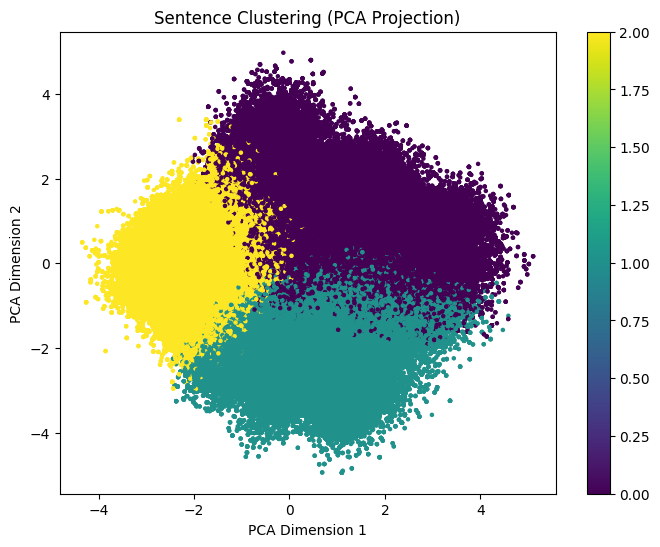

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(premise_embeddings)

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(premise_embeddings)

# Plotting the clusters with PCA reduction
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("Sentence Clustering (PCA Projection)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar()
plt.show()

Query-Based Information Retrieval (With Semantic Matching)

In [18]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: Will you have a coffee?

Top Matches for Query (Diverse Results):
Score: 0.74, Sentence: Are you coming with me for a cup of coffee?
Score: 0.60, Sentence: Two men are having coffee,.
Score: 0.57, Sentence: A woman is drinking her coffee.
Score: 0.57, Sentence: Woman leaves Peet's coffee with a coffee and travel cup.
Score: 0.56, Sentence: The man is having coffee at night.


In [19]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: I am watching a movie.

Top Matches for Query (Diverse Results):
Score: 0.51, Sentence: A man is dressed as a movie character holding a gun in the lobby of a movie theater.
Score: 0.51, Sentence: A lady bowling while watching a movie.
Score: 0.49, Sentence: a line waiting to get into a movie
Score: 0.49, Sentence: An audience is watching and waiting for something to happen.
Score: 0.49, Sentence: The marquee of movies now playing.


In [20]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: Today is a sunny day.

Top Matches for Query (Diverse Results):
Score: 0.80, Sentence: People outside on a sunny day.
Score: 0.78, Sentence: People outside walking and enjoying a sunny day.
Score: 0.74, Sentence: People are walking the streets on a sunny day.
Score: 0.73, Sentence: people walking during a sunny day.
Score: 0.72, Sentence: Group of people on a sunny day.


In [21]:
# Print some premises to verify
print(f"First 5 premises:\n {premises[:5]}")

# Ensure you are encoding the correct data
premise_embeddings = model.encode(premises, show_progress_bar=True)
query_embedding = model.encode(query)  # Encoding only the query

# Verify lengths after encoding
print(f"Length of encoded premises: {len(premise_embeddings)}")
print(f"Length of similarity scores: {len(similarity_scores[0])}")

First 5 premises:
 ('A blond woman sitting with her legs crossed with her eyes closed.', 'An older gentleman standing at a jewelry counter writing a receipt.', 'Two young ballerinas pose before a sign reading "babys".', 'A human figure in a nature-like costume standing as the center of attention at a party.', 'A man in a blue shirt is talking to someone unseen while next to him a woman in a pink sweater closes her eyes.')


Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Length of encoded premises: 550248
Length of similarity scores: 550248


In [22]:
# Assuming you have already defined the similarity scores after encoding
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Verify lengths
print(f"Length of premises: {len(premises)}")
print(f"Length of similarity_scores: {len(similarity_scores[0])}")

Length of premises: 550248
Length of similarity_scores: 550248


Calculating the Difference in Embeddings Between Premise and Hypothesis

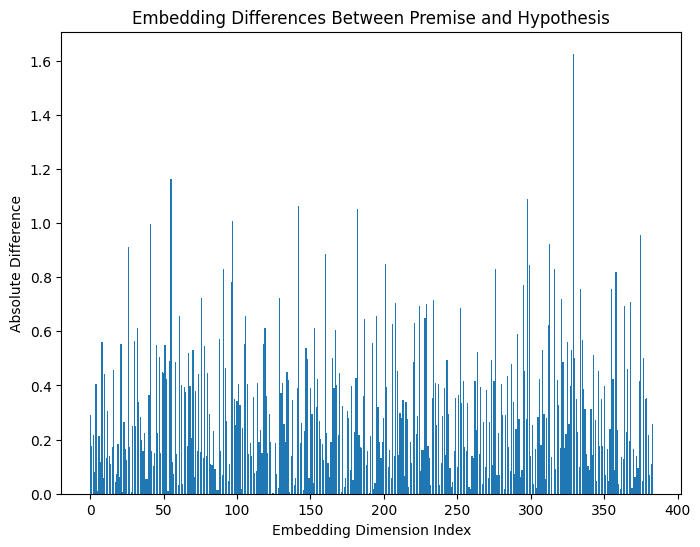

Embedding Difference Example (Premise-Hypothesis):
[2.92273939e-01 1.77991748e-01 2.16069102e-01 8.09087455e-02
 4.05635178e-01 1.10038966e-02 2.15004012e-01 1.18977167e-01
 5.60277820e-01 5.63883036e-02 4.40821826e-01 1.32399574e-01
 3.07347506e-01 1.39884830e-01 1.08538657e-01 1.71873599e-01
 4.58716333e-01 4.32195663e-02 7.39967525e-02 1.82675213e-01
 6.02602959e-02 5.51580369e-01 5.02842665e-03 2.64307499e-01
 1.65260524e-01 1.24100089e-01 9.10661697e-01 1.74414903e-01
 6.00102544e-03 2.50130445e-01 5.64328790e-01 2.48547137e-01
 6.11209631e-01 3.38570595e-01 2.84684658e-01 1.99576199e-01
 1.57080695e-01 2.25980192e-01 5.51539660e-02 5.38870245e-02
 3.64389837e-01 9.97646093e-01 1.59102261e-01 1.03613347e-01
 1.49969906e-01 5.48825324e-01 2.24164456e-01 5.05667567e-01
 1.51598930e-01 4.48839098e-01 4.47711736e-01 5.48749804e-01
 4.24940169e-01 9.11688805e-03 4.89869624e-01 1.16208911e+00
 1.15778185e-01 7.39343613e-02 4.87770140e-01 1.45593196e-01
 3.05054635e-02 6.56993151e-01 4.0

In [23]:
import numpy as np

# Example: Calculate the difference in embeddings between premise and hypothesis
embedding_diff = np.abs(premise_embeddings[0] - hypothesis_embeddings[0])

# Visualize the embedding differences for the first sentence pair
plt.figure(figsize=(8, 6))
plt.bar(range(len(embedding_diff)), embedding_diff)
plt.title("Embedding Differences Between Premise and Hypothesis")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Absolute Difference")
plt.show()

print("Embedding Difference Example (Premise-Hypothesis):")
print(embedding_diff)

Visualizing Sentence Embedding Distributions

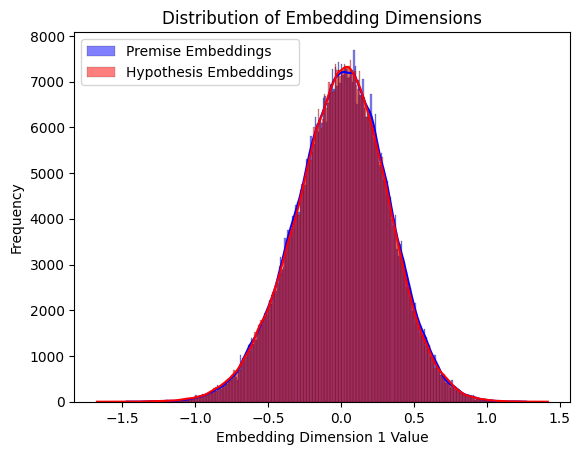

In [24]:
import seaborn as sns

# Visualize the distribution of the first dimension of premise embeddings
sns.histplot(premise_embeddings[:, 0], kde=True, color='blue', label='Premise Embeddings')
sns.histplot(hypothesis_embeddings[:, 0], kde=True, color='red', label='Hypothesis Embeddings')
plt.legend()
plt.title("Distribution of Embedding Dimensions")
plt.xlabel("Embedding Dimension 1 Value")
plt.ylabel("Frequency")
plt.show()